In [1]:
%reload_ext autoreload
%autoreload 2

from lib.data_loading import load_measurements, MixedDataLoader

####

from pathlib import Path
from typing import Tuple, Dict, Any, Callable

import jax
import jax.lax
import jax.numpy as jnp
from jax.random import PRNGKey
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt

data_dir = Path("data")
model_dir = "./models"

print(f"Data resides in                         : {data_dir}")

Data resides in                         : data


In [2]:
class ConditionalRBM(nn.Module):
    num_visible: int
    num_hidden: int
    conditioner_width: int = 64
    k: int = 1
    T: float = 1.0

    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.num_visible, self.num_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.num_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.num_hidden,))

    @nn.compact
    def conditioner(self, field: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        # field shape: (B,) or (B, 1)
        x = field[:, None] if field.ndim == 1 else field       # ensure shape (B, 1)
        x = nn.Dense(self.conditioner_width)(x)                # (B, conditioner_width)
        x = nn.tanh(x)
        x = nn.Dense(2 * (self.num_visible + self.num_hidden))(x)  # (B, 2*(N+H))
        split_indices = [self.num_visible, 2 * self.num_visible, 2 * self.num_visible + self.num_hidden]
        gamma_b, beta_b, gamma_c, beta_c = jnp.split(x, split_indices, axis=-1)
        return gamma_b, beta_b, gamma_c, beta_c

    @nn.nowrap
    def forward_conditioner(self, field: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        return self.conditioner(field)

    @staticmethod
    def _free_energy(v, W, b, c) -> jnp.ndarray:
        return -(v @ b) - jnp.sum(jax.nn.softplus(v @ W + c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c) / T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b) / T)).astype(jnp.float32)
        return v, key

    def __call__(self, batch: Tuple[jnp.ndarray, jnp.ndarray], aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        measurement, field = batch  # (B, N), (B,)
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(field)  # all shape (B, N/H)

        b_mod = (1 + gamma_b) * self.b + beta_b  # (B, N)
        c_mod = (1 + gamma_c) * self.c + beta_c  # (B, H)

        key, key_init = jax.random.split(aux_vars["key"])
        gibbs_chain = jax.random.bernoulli(key_init, 0.5, shape=measurement.shape).astype(jnp.float32)

        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W, b_mod, c_mod, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (gibbs_chain, key))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain)

        free_energy_data  = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(measurement, self.W, b_mod, c_mod)
        free_energy_model = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(gibbs_chain, self.W, b_mod, c_mod)

        free_energy_delta = free_energy_data - free_energy_model
        free_energy_mean = jnp.mean(free_energy_delta)
        free_energy_std  = jnp.std(free_energy_delta)

        l2_regularization = (
                jnp.sum((self.b[None, :] - b_mod) ** 2) +
                jnp.sum((self.c[None, :] - c_mod) ** 2)
        )

        loss = free_energy_mean + aux_vars["l2_strength"] * l2_regularization

        aux_vars_out = {
            "key": key,
            "free_energy_mean": free_energy_mean,
            "free_energy_std": free_energy_std,
        }

        return loss, aux_vars_out

    @nn.nowrap
    def free_energy(self, v: jnp.ndarray) -> jnp.ndarray:
        return self._free_energy(v)

    @nn.nowrap
    def generate(self, field: jnp.ndarray, T_schedule: jnp.ndarray, key: PRNGKey) -> Tuple[jnp.ndarray, PRNGKey]:
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(field)

        b_mod = (1 + gamma_b) * self.b + beta_b
        c_mod = (1 + gamma_c) * self.c + beta_c

        batch_size = field.shape[0]
        key, key_init = jax.random.split(key, 2)

        gibbs_chain = jax.random.bernoulli(key_init, 0.5, shape=(batch_size, self.num_visible)).astype(jnp.float32)
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W, b_mod, c_mod, T_schedule[i])
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (gibbs_chain, key))

        return gibbs_chain, key

In [3]:
@jax.jit
def train_step(
        state: TrainState,
        batch: Tuple[jnp.ndarray, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:

    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, aux_vars


def train(
        state: TrainState,
        loader: MixedDataLoader,
        num_epochs: int,
        key: PRNGKey,
        l2_strength: float,
        lr_schedule_fn: Callable[[int], float]) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    gibbs_chain = None

    for epoch in range(num_epochs):
        tot_loss = 0.0

        for batch_bits, batch_field in loader:
            if gibbs_chain is None:
                gibbs_chain = jax.random.bernoulli(key, 0.5, shape=batch_bits.shape).astype(jnp.float32)

            key, subkey = jax.random.split(key)
            aux_vars = {
                "key": subkey,
                "l2_strength": l2_strength,
            }

            batch = (batch_bits, batch_field)

            state, loss, aux_vars = train_step(state, batch, aux_vars)
            key = aux_vars["key"]
            free_energy_mean = aux_vars["free_energy_mean"]
            free_energy_std = aux_vars["free_energy_std"]

            tot_loss += float(loss)

        avg_loss = tot_loss / len(loader)
        lr = lr_schedule_fn(state.step)

        metrics[epoch] = dict(
            loss=avg_loss,
            free_energy_mean=free_energy_mean,
            free_energy_var=free_energy_std,
            lr=lr
        )

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
              f"Free En. Mean: {free_energy_mean:.4f} │ "
              f"Free En. STD: {free_energy_std:.4f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [4]:
file_names = [
    "tfim_h1.00_3x3_10000.txt",
    "tfim_h2.00_3x3_10000.txt",
    "tfim_h2.80_3x3_10000.txt",
    "tfim_h3.00_3x3_10000.txt",
    "tfim_h3.30_3x3_10000.txt",
    "tfim_h3.60_3x3_10000.txt",
    "tfim_h4.00_3x3_10000.txt",
    "tfim_h5.00_3x3_10000.txt",
    "tfim_h6.00_3x3_10000.txt",
    "tfim_h7.00_3x3_10000.txt",
]

bits_list = []
fields_list = []
for fn in file_names:
    bits, field = load_measurements(data_dir / fn)
    bits_list.append(bits)   # (N, num_qubits)
    fields_list.append(field) # (N,)

bits  = jnp.concatenate(bits_list,  axis=0)  # (2*N, num_qubits)
fields = jnp.concatenate(fields_list, axis=0)

Parsing measurements: 100%|██████████| 10000/10000 [00:00<00:00, 19301.03it/s]


In [5]:
batch_size        = 1024
num_visible       = 9
num_hidden        = 9
conditioner_width = 32
num_epochs        = 100
k_steps           = 100
init_lr           = 1e-2
final_lr          = init_lr * 0.1
l2_strength       = 0.0

key = jax.random.PRNGKey(0)
key, key_params, key_dummy = jax.random.split(key, 3)

model = ConditionalRBM(
    num_visible=num_visible,
    num_hidden=num_hidden,
    conditioner_width=conditioner_width,
    k=k_steps
)

# DUMMY DATA for model init
bits_dummy   = jnp.zeros((batch_size, num_visible), dtype=jnp.float32)
fields_dummy = jnp.zeros((batch_size,), dtype=jnp.float32)
batch_dummy  = (bits_dummy, fields_dummy)
aux_vars_dummy = { "key": key_dummy, "l2_strength": l2_strength }

variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

# Construct loader
loader = MixedDataLoader(bits=bits, field=fields, batch_size=batch_size)

# Learning rate schedule
schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optim = optax.adam(lr_schedule_fn)

# Wrap in training state
state = TrainState.create(apply_fn=model.apply, params=variables["params"], tx=optim)

# Kick off training!
state, metrics = train(state, loader, num_epochs, key, l2_strength, lr_schedule_fn)

Epoch 1/100 │ Loss: +0.0005 │ Free En. Mean: -0.4107 │ Free En. STD: 0.8645 │ Learning Rate: 0.00925
Epoch 2/100 │ Loss: -0.2084 │ Free En. Mean: -0.1809 │ Free En. STD: 2.0522 │ Learning Rate: 0.00922
Epoch 3/100 │ Loss: -0.1044 │ Free En. Mean: -0.1274 │ Free En. STD: 1.7960 │ Learning Rate: 0.00918
Epoch 4/100 │ Loss: -0.0457 │ Free En. Mean: -0.1102 │ Free En. STD: 1.9707 │ Learning Rate: 0.00914
Epoch 5/100 │ Loss: -0.0234 │ Free En. Mean: -0.1537 │ Free En. STD: 1.9389 │ Learning Rate: 0.00911
Epoch 6/100 │ Loss: -0.0149 │ Free En. Mean: -0.0464 │ Free En. STD: 1.9924 │ Learning Rate: 0.00907
Epoch 7/100 │ Loss: -0.0050 │ Free En. Mean: -0.1156 │ Free En. STD: 1.9117 │ Learning Rate: 0.00902
Epoch 8/100 │ Loss: -0.0018 │ Free En. Mean: -0.0134 │ Free En. STD: 2.0350 │ Learning Rate: 0.00898
Epoch 9/100 │ Loss: +0.0052 │ Free En. Mean: 0.0345 │ Free En. STD: 1.8658 │ Learning Rate: 0.00894
Epoch 10/100 │ Loss: -0.0005 │ Free En. Mean: 0.0008 │ Free En. STD: 1.8535 │ Learning Rate:

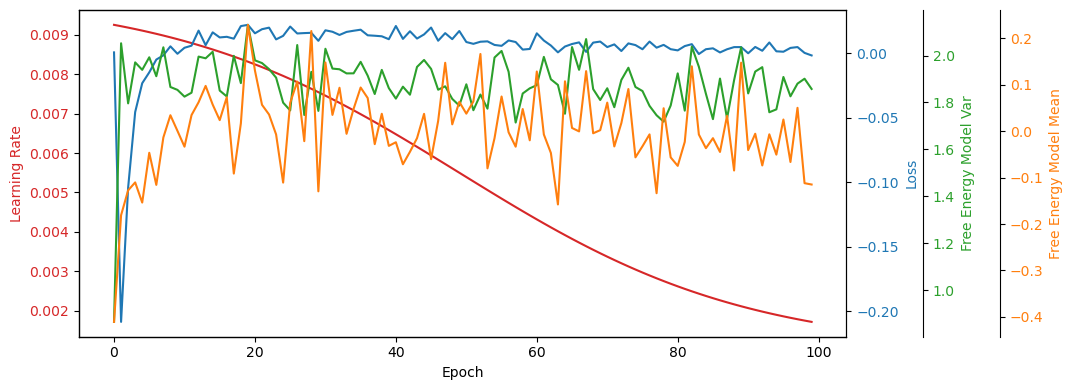

In [6]:
epochs = list(metrics.keys())

loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [11]:
from jax.random import PRNGKey

# Sampling config
sampling_steps = 1000
T_schedule = jnp.full((sampling_steps,), 1.0, dtype=jnp.float32)

# Set the magnetic field to 2.8
num_samples = 10_000
# [1.0, 2.0, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]

field_value = 2.0
field = jnp.full((num_samples,), field_value, dtype=jnp.float32)

# Sampling key
key_sample = PRNGKey(1234)

# Generate samples using the trained model
samples, key_sample = model.apply(
    {"params": state.params},
    field,
    T_schedule,
    key_sample,
    method=ConditionalRBM.generate
)

# Analyze frequency of 1s per spin
sampled_freq = samples.mean(axis=0)
print(sampled_freq)

[0.53709996 0.5406     0.5399     0.5432     0.5369     0.5414
 0.53709996 0.5365     0.54719996]


In [12]:
def magnetization_z(samples: jnp.ndarray) -> jnp.ndarray: # (num_samples, num_qubits)
    # making sure it is not unsigned when changing to -1 and +1 domain
    samples = samples.astype(jnp.float32)  # ensure float for division
    spins = 1 - 2 * samples  # map 0 -> +1, 1 -> -1
    sample_magnetisations = jnp.abs(spins.mean(axis=1)) # the .abs gives us the spontaneous magnetization
    total_magnetisation = sample_magnetisations.mean()
    return total_magnetisation  # mean over samples, gives us the global magnetization

mag_z = magnetization_z(samples)
mag_z

Array(0.808689, dtype=float32)

In [13]:
import flax

def amplitude_ratio_flip(
        model: ConditionalRBM,
        params: flax.core.FrozenDict,
        sample: jnp.ndarray,         # shape (batch_size, num_visible)
        flip_idx: int
) -> jnp.ndarray:
    # flip that one bit
    sample_flipped = sample.at[:, flip_idx].set(1 - sample[:, flip_idx])

    # compute F(v) and F(v') via apply+method
    F_ref  = model.apply({"params": params}, sample,        method=ConditionalRBM.free_energy)
    F_flip = model.apply({"params": params}, sample_flipped, method=ConditionalRBM.free_energy)

    # amplitude ratio = exp[(F(v) - F(v'))/2]
    return jnp.exp((F_ref - F_flip) / 2)


def magnetization_x(
        model: ConditionalRBM,
        params: flax.core.FrozenDict,
        samples: jnp.ndarray          # shape (batch_size, num_visible)
) -> jnp.ndarray:
    # for each qubit index i, get a vector of ratios shape (batch,)
    flip_fn = lambda i: amplitude_ratio_flip(model, params, samples, i)
    # vmap over the spin index axis → (num_visible, batch_size)
    qubit_ratios = jax.vmap(flip_fn)(jnp.arange(samples.shape[1]))
    # average over qubits *and* batch:
    return qubit_ratios.mean()


mag_x = magnetization_x(model, state.params, samples)
mag_x

TypeError: _free_energy() missing 3 required positional arguments: 'W', 'b', and 'c'